Using TensorFlow backend.
C:\Users\Precisit\Anaconda3\envs\NaturalLanguageToCode\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Precisit\Anaconda3\envs\NaturalLanguageToCode\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Precisit\Anaconda3\envs\NaturalLanguageToCode\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

nb_tags: 46ntags: {'RP', '-LRB-', 'NN', 'NNPS', 'VBN', 'JJ', 'PRP', '#', 'LS', 'VBP', "''", 'VBG', 'PDT', 'DT', '$', 'CC', 'WRB', 'WP$', 'UH', 'NNP', '-NONE-', 'JJR', ',', 'POS', 'VBZ', 'IN', 'SYM', 'EX', 'VB', 'RBR', 'RBS', 'JJS', 'FW', '``', 'WDT', '-RRB-', 'VBD', '.', 'CD', 'PRP$', 'NNS', 'MD', ':', 'RB', 'TO', 'WP'}
978
Maximum sentence length: 92


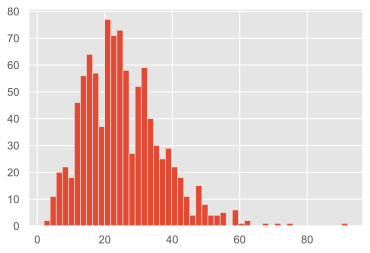

In [1]:
import nltk
import matplotlib.pyplot as plt
from keras import Input, regularizers
from keras_preprocessing.sequence import pad_sequences
from pygments.lexers import go
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from tensorflow import keras
from nltk.corpus import treebank
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#================================================================================================#
#========================Proccesing the data for the models======================================#
nltk.download('treebank')
sentences = treebank.tagged_sents()
sentences = sentences[:len(sentences) //4]
tags = set([
    tag for sentence in treebank.tagged_sents()
    for _, tag in sentence
])
print('nb_tags: %sntags: %s' % (len(tags), tags)) #number of tags we got
print(len(sentences))



train_test_cutoff = int(.80 * len(sentences))
training_sentences = sentences[:train_test_cutoff]
testing_sentences = sentences[train_test_cutoff:]
train_val_cutoff = int(.25 * len(training_sentences))
validation_sentences = training_sentences[:train_val_cutoff]
training_sentences = training_sentences[train_val_cutoff:]

#These properties could include information about
# previous and next words as well as prefixes and suffixes.
def add_basic_features(sentence_terms, index):
    """ Compute some very basic word features.
        :param sentence_terms: [w1, w2, ...]
        :type sentence_terms: list
        :param index: the index of the word
        :type index: int
        :return: dict containing features
        :rtype: dict
    """
    term = sentence_terms[index]
    return {
        'nb_terms': len(sentence_terms),
        'term': term,
        'is_first': index == 0,
        'is_last': index == len(sentence_terms) - 1,
        'is_capitalized': term[0].upper() == term[0],
        'is_all_caps': term.upper() == term,
        'is_all_lower': term.lower() == term,
        'prefix-1': term[0],
        'prefix-2': term[:2],
        'prefix-3': term[:3],
        'suffix-1': term[-1],
        'suffix-2': term[-2:],
        'suffix-3': term[-3:],
        'prev_word': '' if index == 0 else sentence_terms[index - 1],
        'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
    }

def untag(tagged_sentence):
    """
    Remove the tag for each tagged term.
    :param tagged_sentence: a POS tagged sentence
    :type tagged_sentence: list
    :return: a list of tags
    :rtype: list of strings
    """
    return [w for w, _ in tagged_sentence]

def transform_to_dataset(tagged_sentences):
    """
    Split tagged sentences to X and y datasets and append some basic features.
    :param tagged_sentences: a list of POS tagged sentences
    :param tagged_sentences: list of list of tuples (term_i, tag_i)
    :return:
    """
    X, y = [], []
    for pos_tags in tagged_sentences:
            for index, (term, class_) in enumerate(pos_tags):
                X.append(add_basic_features(untag(pos_tags), index))
                y.append(class_)
    return X, y

X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(testing_sentences)
X_val, y_val = transform_to_dataset(validation_sentences)

#Our neural network takes vectors as inputs, so we need to convert our dict features to vectors.
# Fit our DictVectorizer with our set of features
dict_vectorizer = DictVectorizer(sparse=False)
dict_vectorizer.fit(X_train + X_test + X_val)
# Convert dict features to vectors
preX_train = X_train
X_train = dict_vectorizer.transform(X_train)
X_test = dict_vectorizer.transform(X_test)
X_val = dict_vectorizer.transform(X_val)

# Fit LabelEncoder with our list of classes
label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test + y_val)
# Encode class values as integers
prey_train = y_train
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

# Convert integers to dummy variables (one hot encoded)
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

def untagger(tagged_sentences):
    X = []
    for pos_tags in tagged_sentences:
                X.append(untag(pos_tags))
    return X
simple_train_sentences = untagger(training_sentences)

#Plot sentences distributed by length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

In [3]:
#================================================================================================#
#========================Building a model======================================#

In [16]:
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
def build_model(input_dim, hidden_neurons, output_dim):
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 512,
    'output_dim': y_train.shape[1],
    'epochs': 5,
    'batch_size': 256,
    'verbose': 1,
    'validation_data': (X_val, y_val),
    'shuffle': True
}

clf = KerasClassifier(**model_params)
hist = clf.fit(X_train, y_train) #trains it
clf.model.save('keras_mlp.h5') #Save trained model to keras_mlp.h5
y_pred = clf.model.predict(X_test, verbose=1).argmax(-1)
y_true = y_test.argmax(-1)

Train on 14560 samples, validate on 4970 samples
Epoch 1/5
14560/14560 [==============================] - 28s 2ms/step - loss: 1.9777 - accuracy: 0.5256 - val_loss: 0.6976 - val_accuracy: 0.8421

In [ ]:
#================================================================================================#
#========================Building a LSTM model======================================#
#https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-visualize-word-embeddings-part-2-ca137a42a97d

In [16]:
from keras.models import Sequential
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.wrappers.scikit_learn import KerasClassifier

from keras.preprocessing import sequence
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution1D, MaxPooling1D, Conv1D
from keras.layers import Dense, Dropout, Activation, LSTM
#class AttentionLayer(object):
#   pass
def create_lstm_model():
    model_lstm = Sequential()
    model_lstm.add(Embedding(X_train.shape[1], 100, input_length=20323))
    #model_cnn.add(Conv1D(num_filters, kernel_size= 3, activation='relu', kernel_regularizer=regularizers.l2(3)))
    model_lstm.add(Dropout(0.2))
    #model_conv.add(Conv1D(64, 5, activation='relu'))
    model_lstm.add(MaxPooling1D())
    #model_conv.add(AttentionLayer())
    model_lstm.add(LSTM(100))
    #model_lstm.add(Flatten())
    model_lstm.add(Dropout(0.2))
    model_lstm.add(Dense(43, activation='softmax')) #Or sigmoid
    model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_lstm

model_lstm = create_lstm_model()
model_lstm.fit(X_train, y_train, validation_split=0.4, epochs = 2)
model_lstm.model.save('lstm.h5') #Save trained model to keras_mlp.h5


Train on 8736 samples, validate on 5824 samples
Epoch 1/2
8736/8736 [==============================] - 2035s 233ms/step - loss: 0.0947 - accuracy: 0.9767 - val_loss: 0.0942 - val_accuracy: 0.9767

C:\Users\Precisit\Anaconda3\envs\NaturalLanguageToCode\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


In [ ]:
#================================================================================================#
#========================Building a CNN model======================================#
#https://www.kaggle.com/hamishdickson/cnn-for-sentence-classification-by-yoon-kim/data

In [5]:
# lets import some stuff
import numpy as np
import pandas as pd

from keras.models import Model
from keras.layers import *
import re
import matplotlib.pyplot as plt
%matplotlib inline
num_filters = 100
embedding_dim = 200
sequence_length = 46

inputs_2 = Input(shape=(X_train.shape[1],), dtype='int32')

#Version 1: val_loss 0.26, val_acc 0.91

def create_cnn_model():
    model_cnn = Sequential()
    model_cnn.add(Embedding(X_train.shape[1], 100, input_length=20323))
    model_cnn.add(Conv1D(num_filters, kernel_size= 3, activation='relu', kernel_regularizer=regularizers.l2(3)))
    #model_cnn.add(Conv1D(num_filters, kernel_size=(4), activation='relu', kernel_regularizer=regularizers.l2(3)))
    #model_cnn.add(Conv1D(num_filters, kernel_size=(5), activation='relu', kernel_regularizer=regularizers.l2(3)))
    model_cnn.add(MaxPooling1D())
    #model_cnn.add(MaxPooling1D(pool_size=4))
    #model_cnn.add(MaxPooling1D(pool_size=5))
    model_cnn.add(Flatten())
    model_cnn.add(Dropout(0.2))
    model_cnn.add(Dense(43, activation='softmax')) #Or sigmoid
    model_cnn.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model_cnn

model_cnn = create_cnn_model()
print(model_cnn.summary())
hist_2 = model_cnn.fit(X_train, y_train, validation_split=0.4, epochs = 2, batch_size=10)
model_cnn.model.save('cnn.h5') #Save trained model to keras_mlp.h5

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20323, 100)        2032300   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20321, 100)        30100     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10160, 100)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1016000)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1016000)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 43)                43688043  
Total params: 45,750,443
Trainable params: 45,750,443
Non-trainable params: 0
__________________________________________

C:\Users\Precisit\Anaconda3\envs\NaturalLanguageToCode\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


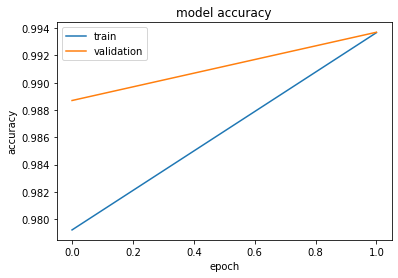

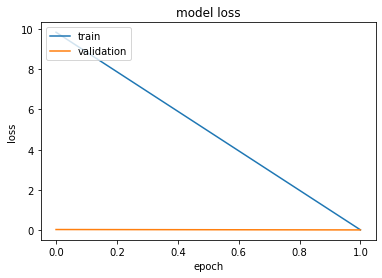

In [17]:
plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#================================================================================================#
#========================Building a RF model======================================#
#https://blog.goodaudience.com/introduction-to-random-forest-algorithm-with-python-9efd1d8f0157
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

#RF_model = RandomForestClassifier('bootstrap': True,'max_depth': 70,'max_features': 'auto', 'min_samples_leaf': 4,'min_samples_split': 10,'n_estimators': 400)
#histRF = RF_model.fit(X_train, y_train)
#RF_predictions = RF_model.predict(X_test)
#score = accuracy_score(y_test ,RF_predictions)
#print(score)
#print('Parameters currently in use:\n')
#print(RF_model.get_params())

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
#================================================================================================#
#========================Visulize the result======================================#

In [20]:
import matplotlib.pyplot as plt
def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'
    # plot model loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')
    # plot model accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, green, linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', color=orange, fontweight='bold')

In [21]:
plot_model_performance(
        train_loss=histRF.history.get('loss', []),
        train_acc=histRF.history.get('accuracy', []),
        train_val_loss=histRF.history.get('val_loss', []),
        train_val_acc=histRF.history.get('val_accuracy', [])
    )
score = accuracy_score(y_test ,RF_predictions)
print(score)


plot_model_performance(
        train_loss=hist.history.get('loss', []),
        train_acc=hist.history.get('accuracy', []),
        train_val_loss=hist.history.get('val_loss', []),
        train_val_acc=hist.history.get('val_accuracy', [])
    )
score = clf.score(X_test, y_test)
print(score)

AttributeError: 'RandomForestClassifier' object has no attribute 'history'

In [ ]:
#================================================================================================#
#========================Visulize the model======================================#

In [27]:
import numpy as np
import itertools
from keras.utils import plot_model
plot_model(model_lstm.model, to_file='model.png', show_shapes=True)


ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [36]:
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
import pickle
from keras.models import load_model
import re


def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 10))
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

model = load_model("cnn.h5")
y_pred = model.predict(X_test, verbose=1).argmax(-1)
cnf_matrix = confusion_matrix(y_test , y_pred)
plot_confusion_matrix(f1_score(y_test, y_pred, average='macro'), cnf_matrix, target_names=con_tags, title='Confusion matrix', normalize=False)

5061/5061 [==============================] - 65s 13ms/step

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
y_pred

In [ ]:
con_tags = {'$',',','-NONE-','JJR','NNS','SYM','TO','UH','VBD','VBN','VBZ','WP$'}

tags

In [ ]:
import matplotlib.pyplot as plt

def plot_acc():
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_acc()

In [ ]:
name='model'
print('\n---- Result of {} ----\n'.format(name))
print(classification_report(y_true, y_pred, digits=4))

